In [2]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
# Load dataset
df = pd.read_csv("D:/23Fall/Forth semester/6260/HW/Midterm2/lyrics_dataset.csv")

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s\']', '', text)  # Keep alphanumeric and apostrophes
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning
df["lyrics"] = df["lyrics"].apply(clean_text)

# Concatenate singer name with lyrics to condition model on the artist
df["text"] = df["singer"] + " " + df["lyrics"]

vocab_size = 20000 
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["text"])

# Remove <OOV> from training text
df["text"] = df["text"].apply(lambda x: " ".join([word for word in x.split() if word != "<OOV>"]))

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["text"])

# Define sequence length
sequence_length = 5  # Shorter sequence length for memory efficiency

# Prepare input-output sequences
input_sequences = []
output_words = []

for seq in sequences:
    for i in range(len(seq) - sequence_length):
        input_sequences.append(seq[i:i + sequence_length])
        output_words.append(seq[i + sequence_length])  # No one-hot encoding

# Convert to numpy arrays
input_sequences = np.array(input_sequences)
output_words = np.array(output_words)

# Check dataset shape
print("Input Shape:", input_sequences.shape)
print("Output Shape:", output_words.shape)

# Train-Test Split (80% Train, 20% Test)
input_train, input_test, output_train, output_test = train_test_split(
    input_sequences, output_words, test_size=0.2, random_state=42)

Input Shape: (1345650, 5)
Output Shape: (1345650,)


In [8]:
# Define Input Layer with Explicit Shape
input_layer = Input(shape=(5,))  # Matches sequence_length

# Add Dropout to Prevent Overfitting
x = Embedding(input_dim=vocab_size, output_dim=100)(input_layer)
x = LSTM(128, return_sequences=True, dropout=0.2)(x)
x = LSTM(128, dropout=0.2)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(vocab_size, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

# Display Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 5, 100)         │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 128)         │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20000)          │     2,580,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,845,344 (18.48 MB)

 Trainable params: 4,845,344 (18.48 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train Model Using Training and Validation Data**
history = model.fit(input_train, output_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(input_test, output_test))

Epoch 1/50
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0862 - loss: 5.9660

D:\Anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8411/8411 ━━━━━━━━━━━━━━━━━━━━ 747s 89ms/step - accuracy: 0.0862 - loss: 5.9659 - val_accuracy: 0.1186 - val_loss: 5.6076
Epoch 2/50
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 837s 99ms/step - accuracy: 0.1245 - loss: 5.4342 - val_accuracy: 0.1372 - val_loss: 5.4166
Epoch 3/50
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 770s 92ms/step - accuracy: 0.1421 - loss: 5.1637 - val_accuracy: 0.1482 - val_loss: 5.3219
Epoch 4/50
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 840s 100ms/step - accuracy: 0.1538 - loss: 4.9880 - val_accuracy: 0.1562 - val_loss: 5.2654
Epoch 5/50
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 830s 99ms/step - accuracy: 0.1615 - loss: 4.8693 - val_accuracy: 0.1629 - val_loss: 5.2339
Epoch 6/50
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 825s 98ms/step - accuracy: 0.1682 - loss: 4.7784 - val_accuracy: 0.1690 - val_loss: 5.2067
Epoch 7/50
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 803s 96ms/step - accuracy: 0.1743 - loss: 4.7037 - val_accuracy: 0.1729 - val_loss: 5.1903
Epoch 8/50
8411/8411 ━━━━━━━━━━━━━━━━━━━━ 820s 97ms/step - accuracy: 0.1794 - l

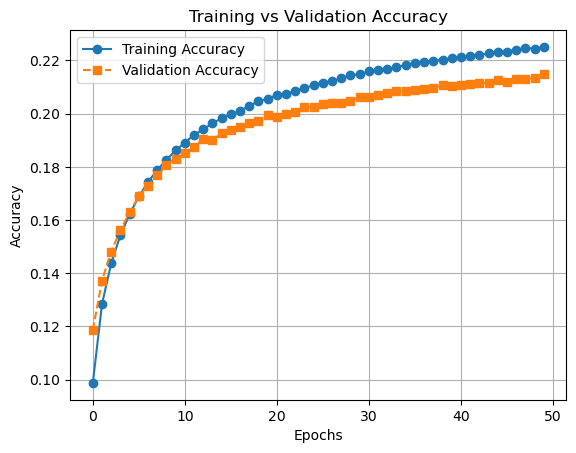

In [14]:
#  Plot Training & Validation Accuracy**
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='s')

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def generate_lyrics_with_temperature(seed_text, model, tokenizer, num_words=50, temperature=1.0):
    sequence_length = 5
    result = seed_text

    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=sequence_length, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]

        # Apply temperature
        predictions = np.log(predictions + 1e-7) / temperature
        predictions = np.exp(predictions)
        predictions /= np.sum(predictions)

        predicted = np.random.choice(len(predictions), p=predictions)

        # Map prediction to word
        output_word = tokenizer.index_word.get(predicted, "")
        if output_word == "<OOV>" or output_word == "":
            continue

        result += " " + output_word
        seed_text += " " + output_word

    return result

# Try it with more creativity
print(generate_lyrics_with_temperature("adele love is", model, tokenizer, temperature=0.8))


adele love is near the way the first cat i don't know which album hakuna matata is bigger than out of her instant protected blue oh i got plenty more back at make sense i know that i felt you love you pyt and you know you love it i'm too young it's
